In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [3]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
df.head(2)

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0


In [9]:
df.corr()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
idno,1.000000,0.002102,0.003963,-0.007523,0.007397,0.004484,-0.003065,-0.021376,0.004323,0.010851,0.030051,-0.014931
year,0.002102,1.000000,-0.031596,-0.001600,0.004283,-0.032901,-0.013378,-0.028502,0.012150,0.001355,-0.003520,0.018689
tvtot,0.003963,-0.031596,1.000000,-0.142422,-0.119277,-0.069080,-0.118598,-0.078864,-0.092375,0.017922,0.257674,-0.028816
ppltrst,-0.007523,-0.001600,-0.142422,1.000000,0.597506,0.459250,0.231533,0.122555,0.137491,-0.029921,-0.029412,-0.034371
pplfair,0.007397,0.004283,-0.119277,0.597506,1.000000,0.480931,0.247755,0.096501,0.128808,0.022251,0.014724,-0.034054
pplhlp,0.004484,-0.032901,-0.069080,0.459250,0.480931,1.000000,0.215323,0.080489,0.092673,0.042046,0.040351,-0.022069
happy,-0.003065,-0.013378,-0.118598,0.231533,0.247755,0.215323,1.000000,0.182944,0.192030,-0.022413,-0.042970,-0.145061
sclmeet,-0.021376,-0.028502,-0.078864,0.122555,0.096501,0.080489,0.182944,1.000000,0.283319,0.009533,-0.194443,0.162970
sclact,0.004323,0.012150,-0.092375,0.137491,0.128808,0.092673,0.192030,0.283319,1.000000,-0.031648,-0.059442,0.011405
gndr,0.010851,0.001355,0.017922,-0.029921,0.022251,0.042046,-0.022413,0.009533,-0.031648,1.000000,0.020598,0.033984


In [4]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] -1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets
offset = int(X.shape[0]*0.9)

# Put 90% of the data in the training set
X_train, y_train = X[:offset], y[:offset]

# and put 10% of data in the test set
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier. Now our loss function can't be the residuals. Our options are "deviance", or "exponential". Deviance is used for logistic regression, and we'll try that here.

In [6]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface. But they aren't quite a black box. We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

Text(0.5, 1.0, 'Variable Importance')

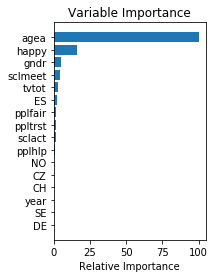

In [7]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

# DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications


In [ ]:
# Itteration 2

Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0004091653027823241

Test set accuracy:
Percent Type I errors: 0.10552147239263804
Percent Type II errors: 0.18404907975460122


Text(0.5, 1.0, 'Variable Importance')

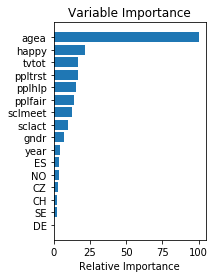

In [10]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 7,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Now we will try to improve our model by tunning parametrs using a grid search

In [11]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [26]:

clf = ensemble.GradientBoostingClassifier(**params)
param_grid = {'n_estimators':[40, 60, 80, 100], 
                'learning_rate':[0.001, 0.05, 0.1, 0.2],
               'max_depth':[2, 3, 4, 6, 8],
               }

CV_rfc = GridSearchCV(estimator=ensemble.GradientBoostingClassifier(), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 40}


In [27]:
CV_rfc.best_score_


0.7257228587015822

Let's fit a model with those parameters and see how it fares in cross-validation on the tuning dataset.

Training set accuracy:
Percent Type I errors: 0.028641571194762683
Percent Type II errors: 0.2273595199127114

Test set accuracy:
Percent Type I errors: 0.04539877300613497
Percent Type II errors: 0.22208588957055214


Text(0.5, 1.0, 'Variable Importance')

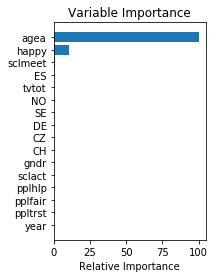

In [28]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 40,
          'max_depth': 2,
          'loss': 'deviance',
         'learning_rate': 0.05}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')